In [1]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# TensorFlow and tf.keras
# import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow_datasets as tfds

In [3]:
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


# Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

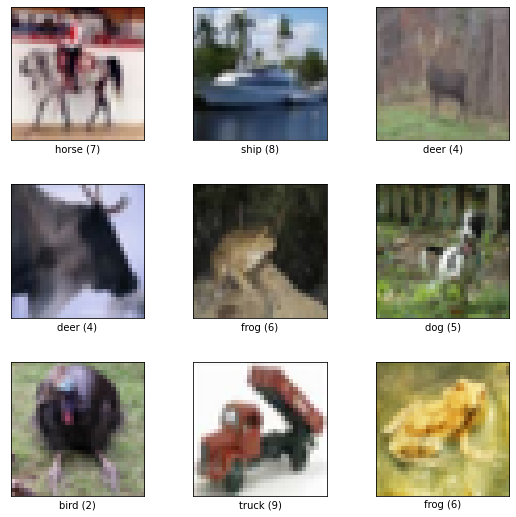

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

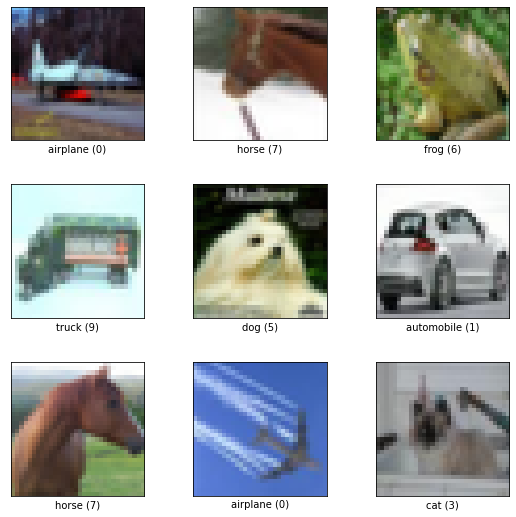

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

# CIFAR-10 데이터셋 학습 (ResNet34, 50)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D, Add, Activation, BatchNormalization, Dropout

In [13]:
BATCH_SIZE = 256
EPOCH = 20

checkpoint_dir = './models/'

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='auto',
                                                save_best_only=True,
                                                verbose=1)

# ResNet 기본 블록 구성

- ResNet34

In [29]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding='same', strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
        
    return x

def bottleneck_identity(input_tensor, filter_sizes, strides=1):
    filter_1, filter_2 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, 3, strides=strides)
    x = conv2d_bn(x, filter_2, 3, activation=None)
    
    shortcut = Add()([input_tensor, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

def bottleneck_projection(input_tensor, filter_sizes, strides=2):
    filter_1, filter_2 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, 3, strides=strides)
    x = conv2d_bn(x, filter_2, 3, activation=None)
    
    projected_input = conv2d_bn(input_tensor, filter_2, 1, strides=strides, activation=None)
    shortcut = Add()([projected_input, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

In [34]:
inputs = Input(shape=(32, 32, 3))
x = conv2d_bn(inputs, 64, 7, strides=2, padding='same')
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = bottleneck_projection(x, [64, 64], strides=1)
x = bottleneck_identity(x, [64, 64])
x = bottleneck_identity(x, [64, 64])

x = bottleneck_projection(x, [128, 128])
x = bottleneck_identity(x, [128, 128])
x = bottleneck_identity(x, [128, 128])
x = bottleneck_identity(x, [128, 128])

x = bottleneck_projection(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
    
x = bottleneck_projection(x, [512, 512])
x = bottleneck_identity(x, [512, 512])
x = bottleneck_identity(x, [512, 512])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

model_output = Dense(10, activation='sigmoid', kernel_initializer='he_normal')(x)

resnet34 = Model(inputs=inputs, outputs=model_output, name='ResNet34')

In [31]:
resnet34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 112, 112, 64) 256         conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_90[0][0]     
___________________________________________________________________________________________

In [32]:
tf.keras.utils.plot_model(resnet34, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [33]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

Epoch 1/20


ValueError: in user code:

    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ssac2/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer ResNet34: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)


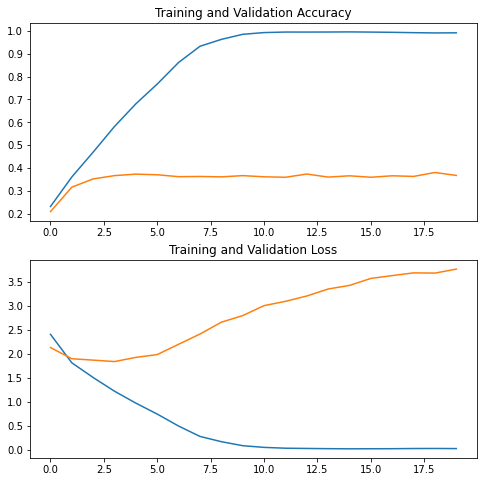

In [28]:
# history for acc and loss graph
import matplotlib.pyplot as plt

acc = history_34.history['accuracy']
val_acc = history_34.history['val_accuracy']

loss = history_34.history['loss']
val_loss = history_34.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
resnet34.save('./models/res34_model_e20.h5')

- ResNet-50

In [23]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

def bottleneck_identity(input_tensor, filter_sizes):
    filter_1, filter_2, filter_3 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, 1)
    x = conv2d_bn(x, filter_2, 3)
    x = conv2d_bn(x, filter_3, 1, activation=None)
    
    shortcut = Add()([input_tensor, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

def bottleneck_projection(input_tensor, filter_sizes, strides=2):
    filter_1, filter_2, filter_3 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, 1, strides=strides)
    x = conv2d_bn(x, filter_2, 3)
    x = conv2d_bn(x, filter_3, 1, activation=None)
    
    projected_input = conv2d_bn(input_tensor, filter_3, 1, strides=strides, activation=None)
    shortcut = Add()([projected_input, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

In [24]:
inputs = Input(shape=(32, 32, 3))
x = conv2d_bn(inputs, 64, 7, strides=2, padding='same')
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = bottleneck_projection(x, [64, 64, 256], strides=1)
x = bottleneck_identity(x, [64, 64, 256])
x = bottleneck_identity(x, [64, 64, 256])

x = bottleneck_projection(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])

x = bottleneck_projection(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
    
x = bottleneck_projection(x, [512, 512, 2048])
x = bottleneck_identity(x, [512, 512, 2048])
x = bottleneck_identity(x, [512, 512, 2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

model_output = Dense(10, activation='sigmoid', kernel_initializer='he_normal')(x)

resnet50 = Model(inputs=inputs, outputs=model_output, name='ResNet50')

In [25]:
resnet50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 16, 16, 64)   256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_37[0][0]     
___________________________________________________________________________________________

In [26]:
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [27]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback]
)

Epoch 1/20
 81/195 [===========>..................] - ETA: 30s - loss: 3.2189 - accuracy: 0.1080

ResourceExhaustedError:  OOM when allocating tensor with shape[256,256,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node ResNet50/conv2d_62/Conv2D (defined at <ipython-input-27-898daa270afd>:15) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_42405]

Function call stack:
train_function


In [ ]:
# history for acc and loss graph
acc = history_50.history['accuracy']
val_acc = history_50.history['val_accuracy']

loss = history_50.history['loss']
val_loss = history_50.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper left')
plt.show()